# Convolutional Autoencoder with Deconvolutions (without pooling operations)

![](images/autoencoder/autoencoder-arch.png)

In [3]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['/Users/ZRC/miniconda3/envs/tryit/lib/python36.zip',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/lib-dynload',
 '',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages/IPython/extensions',
 '/Users/ZRC/.ipython',
 '/Users/ZRC']

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import Subset


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [6]:
from coke.visualization.image import show_batch

## Model Settings

In [28]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
RANDOM_SEED = 7

# Architecture
NUM_CLASSES = 10
GRAYSCALE = True

# # other
# torch.cuda.empty_cache()
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [8]:
data_transforms = {"train": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()]),
                    "test": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()])
                   }

In [9]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)



train_and_valida_dataset = datasets.MNIST(root = "data",
                                train = True,
                                transform = data_transforms["train"],
                                download=True)

test_dataset = datasets.MNIST(root = "data",
                                train = False,
                                transform = data_transforms["test"],
                                download=False)

train_dataset = Subset(train_and_valida_dataset, train_indices)
valid_dataset = Subset(train_and_valida_dataset, valid_indices)




train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

valid_dataloader = DataLoader(dataset = valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

data_loader = {"train": train_dataloader, 
               "val": valid_dataloader,
               "test": test_dataloader}

torch.Size([64, 1, 32, 32]) torch.Size([64])


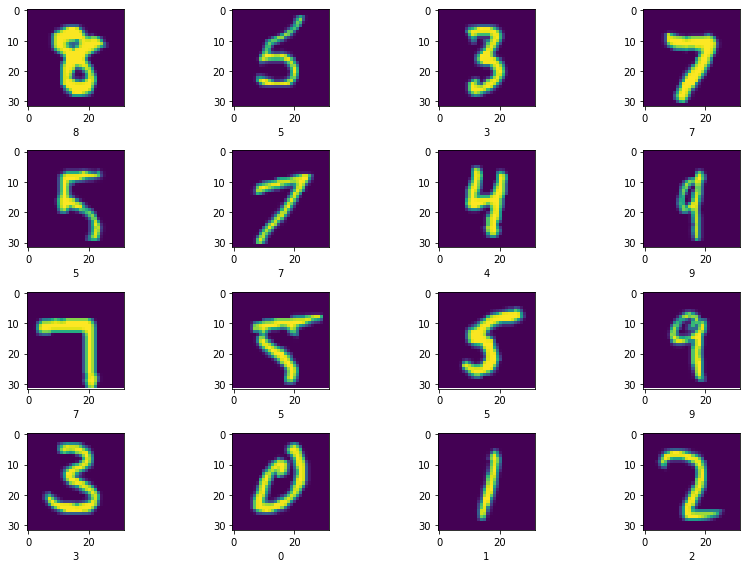

In [10]:
batch_samples,labels = next(iter(train_dataloader))
print(batch_samples.size(),labels.size())
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


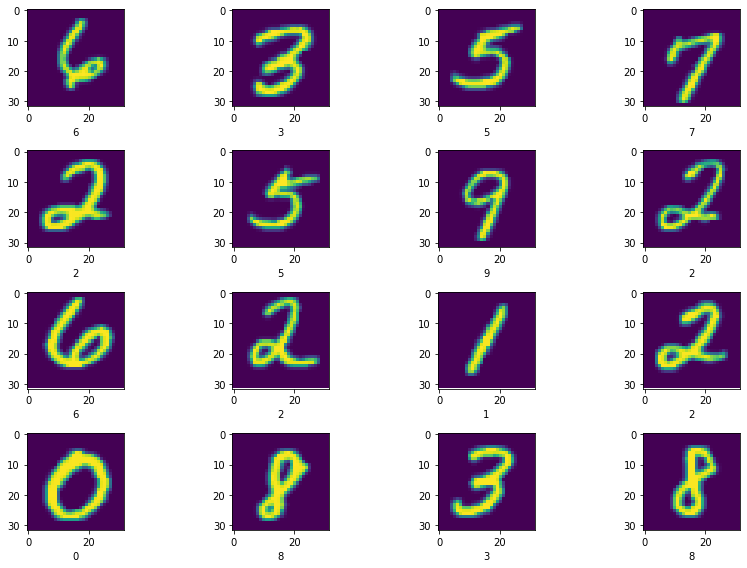

In [11]:
batch_samples,labels = next(iter(valid_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


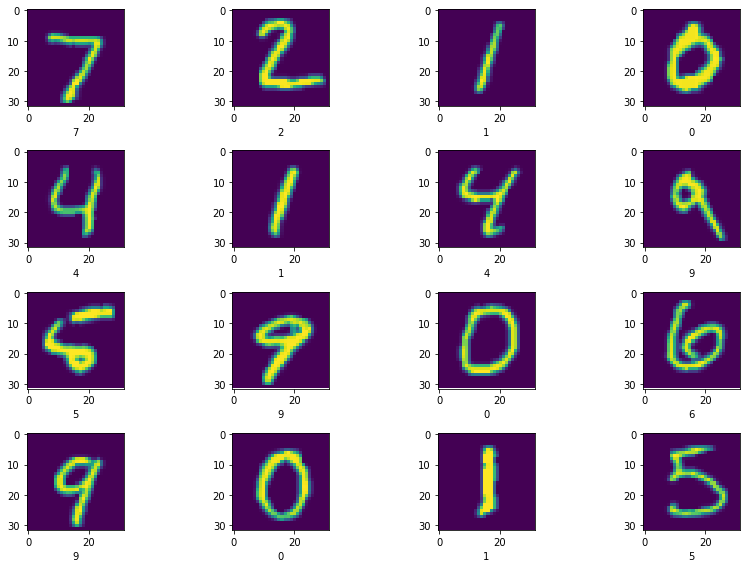

In [12]:
batch_samples,labels = next(iter(test_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

## Model

In [50]:
class AutoEncoderZrc(torch.nn.Module):
    def __init__(self, grayscale = False):
        super(AutoEncoderZrc, self).__init__()
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        if grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        
        # (w-k+2p) // 2 + 1
        
        # 28x28x1 => 14x14x4
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels,
                            out_channels=4,
                            kernel_size=(3, 3),
                            stride=(2, 2),
                            padding=1),
            torch.nn.LeakyReLU(inplace = True),
            # 14x14x4 => 7x7x8
            torch.nn.Conv2d(in_channels=4,
                              out_channels=8,
                              kernel_size=(3, 3),
                              stride=(2, 2),
                              padding=1),
            torch.nn.LeakyReLU(inplace = True)
        )
        
        # Hout=(H−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
        
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=8,
                                     out_channels=4,
                                     kernel_size=(3, 3),
                                     stride=(2, 2),
                                     padding = 1,
                                     output_padding = 1),
            torch.nn.LeakyReLU(inplace = True),
            torch.nn.ConvTranspose2d(in_channels = 4,
                            out_channels= in_channels,
                            kernel_size=(3, 3),
                            stride=(2, 2),
                            padding = 1,
                            output_padding = 1),
                            
            torch.nn.LeakyReLU(inplace = True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x
        

In [87]:
def test_nin():
    model = AutoEncoderZrc().to(DEVICE)
    summary(model, (3,32,32))
    
test_nin()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 16, 16]             112
         LeakyReLU-2            [-1, 4, 16, 16]               0
            Conv2d-3              [-1, 8, 8, 8]             296
         LeakyReLU-4              [-1, 8, 8, 8]               0
   ConvTranspose2d-5            [-1, 4, 16, 16]             292
         LeakyReLU-6            [-1, 4, 16, 16]               0
   ConvTranspose2d-7            [-1, 3, 32, 32]             111
         LeakyReLU-8            [-1, 3, 32, 32]               0
Total params: 811
Trainable params: 811
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.00
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [52]:
model = AutoEncoderZrc(grayscale=GRAYSCALE)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func = None, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)

            ## forward pass
            decoded = model(features)
            loss = F.binary_cross_entropy(decoded, features)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))
    return loss_list, model

In [65]:
loss_list = train_model(model, 
            data_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE)

Epoch: 001/010 | Batch 000/921 | Loss: 0.10
Epoch: 001/010 | Batch 050/921 | Loss: 0.10
Epoch: 001/010 | Batch 100/921 | Loss: 0.10
Epoch: 001/010 | Batch 150/921 | Loss: 0.10
Epoch: 001/010 | Batch 200/921 | Loss: 0.09
Epoch: 001/010 | Batch 250/921 | Loss: 0.10
Epoch: 001/010 | Batch 300/921 | Loss: 0.10
Epoch: 001/010 | Batch 350/921 | Loss: 0.10
Epoch: 001/010 | Batch 400/921 | Loss: 0.10
Epoch: 001/010 | Batch 450/921 | Loss: 0.10
Epoch: 001/010 | Batch 500/921 | Loss: 0.10
Epoch: 001/010 | Batch 550/921 | Loss: 0.10
Epoch: 001/010 | Batch 600/921 | Loss: 0.11
Epoch: 001/010 | Batch 650/921 | Loss: 0.10
Epoch: 001/010 | Batch 700/921 | Loss: 0.10
Epoch: 001/010 | Batch 750/921 | Loss: 0.10
Epoch: 001/010 | Batch 800/921 | Loss: 0.10
Epoch: 001/010 | Batch 850/921 | Loss: 0.10
Epoch: 001/010 | Batch 900/921 | Loss: 0.10
Epoch: 002/010 | Batch 000/921 | Loss: 0.10
Epoch: 002/010 | Batch 050/921 | Loss: 0.10
Epoch: 002/010 | Batch 100/921 | Loss: 0.10
Epoch: 002/010 | Batch 150/921 |

Epoch: 010/010 | Batch 800/921 | Loss: 0.10
Epoch: 010/010 | Batch 850/921 | Loss: 0.10
Epoch: 010/010 | Batch 900/921 | Loss: 0.10


In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

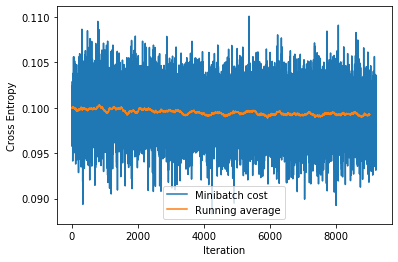

In [67]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [78]:
test_batch, test_tagret = next(iter(data_loader["test"]))
model(test_batch).shape

(2, 15)

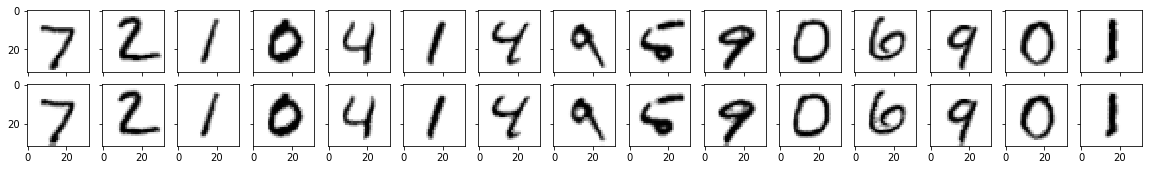

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 32

# axes (2,15)
fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

orig_images = test_batch
decoded_images = model(test_batch)

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

axes.shape

## Reference

- https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a
- https://github.com/rasbt/deeplearning-models